# Off-Axis Propagation

Below we see how to propagate off-axis, namely shift the destination plane as in [this paper](https://opg.optica.org/oe/fulltext.cfm?uri=oe-18-17-18453&id=205150).
This can reduce the FFT size if one is interested in the field off-axis, instead of having to propagate large fields.

Let's create a rectangular aperture at the input.

Field shape [um]:  1089.536
Width of aperture [um]:  544.768
Propagation distance [um]:  108953.6


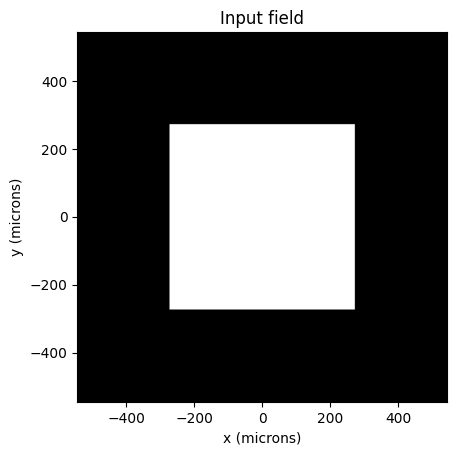

In [1]:
from functools import partial

import jax
import matplotlib.pyplot as plt
import numpy as np
from jax import device_put

import chromatix.functional as cf
from chromatix.field import shift_grid
from chromatix.utils import plot_field

shape = (1024, 1024)
N_pad = (512, 512)  # padding to linearize the FFT
spectrum = 0.532  # wavelength
dxi = 2 * spectrum
D = dxi * shape[0]  # field shape
w = D / 2  # width of aperture
z = 100 * D  # propagation distance
dxi = D / np.array(shape)
spacing = dxi[..., np.newaxis]
n = 1  # refractive index of medium
gpu_device = 0

print("Field shape [um]: ", D)
print("Width of aperture [um]: ", w)
print("Propagation distance [um]: ", z)

field = cf.plane_wave(
    shape=shape,
    dx=spacing,
    spectrum=spectrum,
    spectral_density=1.0,
    pupil=partial(cf.square_pupil, w=w),
)
field = device_put(field, jax.devices()[gpu_device])

ax = plot_field(field)
ax.set_title("Input field")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)");

By default, a field is centered at the origin but we can shift the field.

Original spatial limits (y, x):  [(-544, 543), (-544, 543)]
Shifted spatial limits  (y, x):  [(-544, 543), (0, 1088)]


Text(0.5, 0, 'x (microns)')

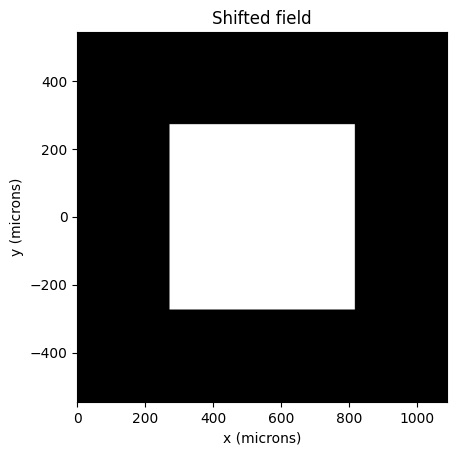

In [2]:
shift_yx = (0, D / 2)  # along x-axis
# shift_yx = (D / 2, 0)  # along y-axis
shifted_field = shift_grid(field, shift_yx=shift_yx)
# print rounded spatial limits
print(
    "Original spatial limits (y, x): ",
    [(int(x[0]), int(x[1])) for x in field.spatial_limits],
)
print(
    "Shifted spatial limits  (y, x): ",
    [(int(x[0]), int(x[1])) for x in shifted_field.spatial_limits],
)

ax = plot_field(shifted_field)
ax.set_title("Shifted field")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)")

Below we show how to propagate a field off-axis. Usually this will be done on a centered field, i.e. as `field` above.

Let's first propagate without shifting the destination plane.

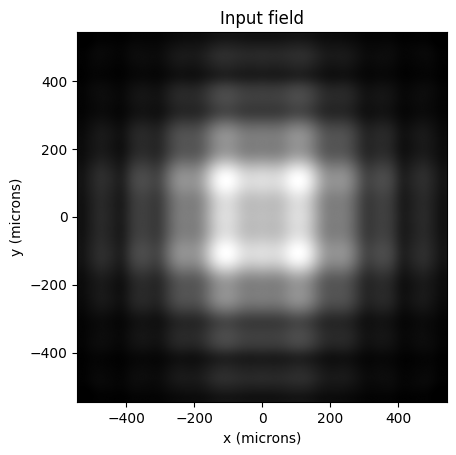

In [3]:
# Bandlimited angular spectrum
out_field_blas = cf.asm_propagate(field, z, n, N_pad=N_pad, mode="same", bandlimit=True)

ax = plot_field(out_field_blas)
ax.set_title("Input field")
ax.set_ylabel("y (microns)")
ax.set_xlabel("x (microns)");

Let's compute the field by a shift of half the aperture width along the x-axis. 

We compare two approaches:
- Adjusting the propagation kernel (as in [this paper](https://opg.optica.org/oe/fulltext.cfm?uri=oe-18-17-18453&id=205150))
- Using the chirp Z-transform (CZT)

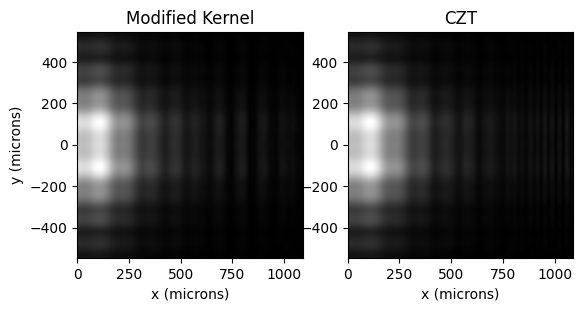

In [4]:
shift_yx = (0, D / 2)

# Angular spectrum (bandlimited with adjust kernel)
shifted_field = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    shift_yx=shift_yx,
)

# Angular spectrum (bandlimited CZT)
shifted_field_czt = cf.asm_propagate(
    field,
    z,
    n,
    N_pad=N_pad,
    mode="same",
    bandlimit=True,
    shift_yx=shift_yx,
    # set spacing to force usage of CZT
    output_dx=spacing,
    use_czt=True,
)

# plot
fig, axs = plt.subplots(1, 2)
plot_field(shifted_field, ax=axs[0])
axs[0].set_title("Modified Kernel")
axs[0].set_xlabel("x (microns)")
axs[0].set_ylabel("y (microns)")
plot_field(shifted_field_czt, ax=axs[1])
axs[1].set_title("CZT")
axs[1].set_xlabel("x (microns)");

By default `use_czt` is set to `False`, as using it is slower than the method mentioned in the above paper. Below we profile the two methods.

In [5]:
## profiling and checking jit compilation
import time

from jax import jit

n_trials = 25

asm_propagate_jit = jit(
    cf.asm_propagate, static_argnames=("N_pad", "bandlimit", "mode", "use_czt")
)

# Angular spectrum (bandlimited with adjust kernel)
start_time = time.perf_counter()
for _ in range(n_trials):
    out_field_asm_jit = asm_propagate_jit(
        field=field,
        z=z,
        n=n,
        N_pad=N_pad,
        bandlimit=True,
        mode="same",
        shift_yx=shift_yx,
    )
    out_field_asm_jit.u.block_until_ready()
print(
    "Avg time for BLAS with adjusted kernel: ",
    (time.perf_counter() - start_time) / n_trials,
)

# Angular spectrum (bandlimited CZT) - takes longer due to CZT
start_time = time.perf_counter()
for _ in range(n_trials):
    out_field_asm_jit_czt = asm_propagate_jit(
        field=field,
        z=z,
        n=n,
        N_pad=N_pad,
        bandlimit=True,
        mode="same",
        shift_yx=shift_yx,
        # # set spacing to force usage of CZT
        output_dx=spacing,
        use_czt=True,
    )
    out_field_asm_jit_czt.u.block_until_ready()
print("Avg time for BLAS with CZT: ", (time.perf_counter() - start_time) / n_trials)

Avg time for BLAS with adjusted kernel:  0.1020186033193022
Avg time for BLAS with CZT:  0.21877838999964297


Using CZT takes longer as it requires more FFTs.

Let's tilt the illumination and shift off-axis (without CZT).

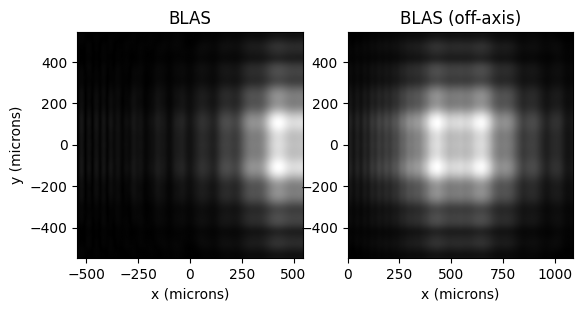

In [6]:
# -- tilt and shift in x
kykx = (0, -5 / w)
shift_yx = (0, D / 2)
# # -- tilt and shift in y
# kykx = (-5 / w, 0)
# shift_yx = (D / 2, 0)

# Angular spectrum
out_blas = cf.asm_propagate(
    field, z, n, N_pad=N_pad, mode="same", bandlimit=True, kykx=kykx
)

# Angular spectrum (shifted)
out_blas_off_axis = cf.asm_propagate(
    field, z, n, N_pad=N_pad, mode="same", bandlimit=True, shift_yx=shift_yx, kykx=kykx
)

# plot
fig, axs = plt.subplots(1, 2)
plot_field(out_blas, ax=axs[0])
axs[0].set_title("BLAS")
axs[0].set_ylabel("y (microns)")
axs[0].set_xlabel("x (microns)")
plot_field(out_blas_off_axis, ax=axs[1])
axs[1].set_title("BLAS (off-axis)")
axs[1].set_xlabel("x (microns)");